# DATA TRANSFORMATION - 1_adherencia
## 0. Previos

Se cargan las bases y las librerías a utilizar.

In [1]:
# Librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

import generic_funcions as gf

ruta_archivos = 'C:/Users/monic/documentos/ds4a/project/datos/'

## 1. Load

In [2]:
dcc = gf.diccionario_llaves()

In [4]:
modulo = 'Adherencia'
ids = ['id', 'year', 'month']

In [5]:
base = gf.carga_datos( ruta = ruta_archivos, diccionario = dcc, modulo = modulo )
base.head()

,id,fecha,Morisky_Green,Smaq1,Smaq2,Espa,nm_espa,Cualitativo_ponderado,Cuantitativo_ponderado,year,month,year_month
0,1101180,2012-04-24,NO ADHERENTE,ADHERENTE,95-100%,NO ADHERENTE,4.0,NO ADHERENTE,95-100%,2012,4,201204
1,1101180,2012-11-26,ADHERENTE,ADHERENTE,95-100%,ADHERENTE,6.0,ADHERENTE,95-100%,2012,11,201211
2,529410,2012-04-19,NO ADHERENTE,ADHERENTE,95-100%,NO ADHERENTE,6.0,NO ADHERENTE,95-100%,2012,4,201204
3,979605,2013-03-04,NO ADHERENTE,ADHERENTE,95-100%,NO ADHERENTE,6.0,NO ADHERENTE,95-100%,2013,3,201303
4,1198956,2012-05-16,NO ADHERENTE,ADHERENTE,95-100%,NO ADHERENTE,6.0,NO ADHERENTE,95-100%,2012,5,201205


## 2. Transform

* Cualitativo_ponderado

In [6]:
base['Cualitativo_ponderado'].unique()

array(['NO ADHERENTE', 'ADHERENTE', 'NO APLICA', nan], dtype=object)

In [9]:
base_ = base.dropna()
base_['Cualitativo_ponderado'].unique()

array(['NO ADHERENTE', 'ADHERENTE', 'NO APLICA'], dtype=object)

In [12]:
def adhere( x ):
    y = 2
    if x == 'NO ADHERENTE' :
        y = 1
    elif x == 'ADHERENTE' :
        y = 0
    return y

variable = 'adherencia_cat'
base_[variable] = base_['Cualitativo_ponderado'].apply( adhere )
print(base_.columns)
base_.groupby(variable)['id'].count()

Index(['id', 'fecha', 'Morisky_Green', 'Smaq1', 'Smaq2', 'Espa', 'nm_espa',
       'Cualitativo_ponderado', 'Cuantitativo_ponderado', 'year', 'month',
       'year_month', 'adherencia_cat'],
      dtype='object')


<ipython-input-12-7573fa7a8553>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_[variable] = base_['Cualitativo_ponderado'].apply( adhere )


adherencia_cat
0    3818
1     989
2     454
Name: id, dtype: int64

In [22]:
base_p = base_.groupby( ids )['adherencia_cat'].max().reset_index( name='adeherencia_0' )

In [23]:
base_p.head()

,id,year,month,adeherencia_0
0,500547,2016,7,0
1,500547,2019,3,0
2,500547,2019,10,0
3,500547,2019,12,0
4,500547,2020,1,0


In [24]:
def periods_aderence( base_p ):
    dy = pd.DataFrame.from_dict( {'year_c': list(range(2016,2021))} )
    dm = pd.DataFrame.from_dict({'month_c': list(range(1,13) )})

    base_p['key'] = 1
    dy['key'] = 1
    dm['key'] = 1

    base_c = base_p.merge(dy, on ='key').merge(dm, on ='key')
    base_c['d_meses'] = ( base_c['year']*12 + base_c['month'] ) - ( base_c['year_c']*12 + base_c['month_c'] )
    base_d = base_c[base_c['d_meses'] > 0 ]

    base_d.rename(columns={'year':'year_obs', 'month':'month_obs'}, inplace=True)

    return base_d

In [25]:
def periods_aderence_futuro( base_p ):
    dy = pd.DataFrame.from_dict( {'year_c': list(range(2016,2021))} )
    dm = pd.DataFrame.from_dict({'month_c': list(range(1,13) )})

    base_p['key'] = 1
    dy['key'] = 1
    dm['key'] = 1

    base_c = base_p.merge(dy, on ='key').merge(dm, on ='key')
    base_c['d_meses'] = ( base_c['year']*12 + base_c['month'] ) - ( base_c['year_c']*12 + base_c['month_c'] )
    base_d = base_c[base_c['d_meses'] <= 0 ]

    base_d.rename(columns={'year':'year_obs', 'month':'month_obs'}, inplace=True)

    return base_d

In [73]:
n_meses = 12

base_x = periods_aderence_futuro( base_p )
base_x = base_x[['id', 'year_obs', 'month_obs','year_c','month_c', 'd_meses']]

base_merge = base_x.merge( base_p , how='left', left_on = ['id', 'year_c', 'month_c'], right_on = ['id', 'year', 'month'] )
base_merge.dropna(inplace = True)
base_merge = base_merge[base_merge['d_meses']>=(1-n_meses)]

base_consolidada = base_merge.groupby(['id','year_obs','month_obs'])[['adeherencia_0','key']].sum().reset_index()
base_consolidada.columns = ['id', 'year', 'month', 'adeherencia_'+str(n_meses), 'cantidad']

base_consolidada.head()


,id,year,month,adeherencia_12,cantidad
0,500547,2016,7,0.0,1.0
1,500547,2019,3,0.0,4.0
2,500547,2019,10,0.0,5.0
3,500547,2019,12,0.0,4.0
4,500547,2020,1,0.0,3.0


In [ ]:
base_merge[ (base_merge['id']==500547) & (base_merge['year_obs']==2019) ]# & (base_merge['month_obs']==12)]

In [ ]:

# do group by
df_h = base_consolidada.groupby(['cantidad'])['id'].count().reset_index(name='gente')


# plot
fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(df_h['cantidad'], df_h['gente'] )



In [ ]:
base_consolidada[base_consolidada['cantidad']==1].describe()



In [ ]:
base_consolidada[base_consolidada['cantidad']>1].describe()

-----------------------------------

In [17]:
base_ = base_[base_[variable] < 2]

In [18]:
base_.groupby(variable)['id'].count()

adherencia_cat
0    3818
1     989
Name: id, dtype: int64

In [19]:
base_p = base_.groupby(ids)[variable].max().reset_index(name='adeherencia_0')
base_p.head()

,id,year,month,adeherencia_0
0,500547,2016,7,0
1,500547,2019,3,0
2,500547,2019,10,0
3,500547,2019,12,0
4,500547,2020,1,0


In [20]:
dy = pd.DataFrame.from_dict( {'year_c': list(range(2016,2021))} )
dm = pd.DataFrame.from_dict({'month_c': list(range(1,13) )})

In [21]:
base_p['key'] = 1
dy['key'] = 1
dm['key'] = 1

In [19]:
base_c = base_p.merge(dy, on ='key').merge(dm, on ='key')#[['id','year','month']]

In [22]:
base_c['d_meses'] = ( base_c['year']*12 + base_c['month'] ) - ( base_c['year_c']*12 + base_c['month_c'] )

In [23]:
base_c.head()

,id,year,month,adeherencia_0,key,year_c,month_c,d_meses
0,500547,2016,7,1,1,2016,1,6
1,500547,2016,7,1,1,2016,2,5
2,500547,2016,7,1,1,2016,3,4
3,500547,2016,7,1,1,2016,4,3
4,500547,2016,7,1,1,2016,5,2


In [25]:
base_d = base_c[base_c['d_meses'] > 0 ]
base_d.head()

,id,year,month,adeherencia_0,key,year_c,month_c,d_meses
0,500547,2016,7,1,1,2016,1,6
1,500547,2016,7,1,1,2016,2,5
2,500547,2016,7,1,1,2016,3,4
3,500547,2016,7,1,1,2016,4,3
4,500547,2016,7,1,1,2016,5,2


In [26]:
base_d[base_d['id'] == 500547]

,id,year,month,adeherencia_0,key,year_c,month_c,d_meses
0,500547,2016,7,1,1,2016,1,6
1,500547,2016,7,1,1,2016,2,5
2,500547,2016,7,1,1,2016,3,4
3,500547,2016,7,1,1,2016,4,3
4,500547,2016,7,1,1,2016,5,2
...,...,...,...,...,...,...,...,...
407,500547,2020,5,1,1,2019,12,5
408,500547,2020,5,1,1,2020,1,4
409,500547,2020,5,1,1,2020,2,3
410,500547,2020,5,1,1,2020,3,2


In [27]:
base_d.describe()

,id,year,month,adeherencia_0,key,year_c,month_c,d_meses
count,1.041250e+05,104125.000000,104125.000000,104125.000000,104125.0,104125.000000,104125.000000,104125.000000
mean,1.239904e+06,2018.528355,6.197666,0.798617,1.0,2017.014713,6.092408,18.268965
std,4.374849e+05,1.027182,3.463666,0.401035,0.0,1.009565,3.433074,12.243597
min,5.005470e+05,2016.000000,1.000000,0.000000,1.0,2016.000000,1.000000,1.000000
25%,8.634620e+05,2018.000000,3.000000,1.000000,1.0,2016.000000,3.000000,8.000000
50%,1.227104e+06,2019.000000,6.000000,1.000000,1.0,2017.000000,6.000000,16.000000
75%,1.629016e+06,2019.000000,9.000000,1.000000,1.0,2018.000000,9.000000,27.000000
max,1.999629e+06,2020.000000,12.000000,1.000000,1.0,2020.000000,12.000000,52.000000


# Revisar después...
Es análisis temporal para variable respuesta

In [72]:
base_p.groupby('no_ad')['id'].count()

no_ad
0    3490
1    1365
Name: id, dtype: int64

In [49]:
base_p.shape

(4855, 4)

In [50]:
4855*4855

23571025

In [86]:
bx = base_p[base_p['id']==500547]
bx

,id,year,month,no_ad
0,500547,2016,7,0
1,500547,2019,3,0
2,500547,2019,10,0
3,500547,2019,12,0
4,500547,2020,1,0
5,500547,2020,3,0
6,500547,2020,5,0


In [60]:
base_t = base_p.merge(base_p[['id','year','month']], how = 'left', left_on = 'id', right_on = 'id' ,suffixes = ('','_d') )

In [61]:
base_t.shape

(46307, 6)

In [73]:
base_t.groupby('no_ad')['id'].count()

no_ad
0    13356
1     7370
Name: id, dtype: int64

In [64]:
base_t['dif_meses'] = ( base_t['year_d']*12 + base_t['month_d'] ) - ( base_t['year']*12 + base_t['month'] )
base_t[base_t['id']==500547].head(14)

,id,year,month,no_ad,year_d,month_d,dif_meses
0,500547,2016,7,0,2016,7,0
1,500547,2016,7,0,2019,3,32
2,500547,2016,7,0,2019,10,39
3,500547,2016,7,0,2019,12,41
4,500547,2016,7,0,2020,1,42
5,500547,2016,7,0,2020,3,44
6,500547,2016,7,0,2020,5,46
7,500547,2019,3,0,2016,7,-32
8,500547,2019,3,0,2019,3,0
9,500547,2019,3,0,2019,10,7


In [65]:
base_t = base_t[ base_t['dif_meses'] >= 0 ]
base_t[base_t['id']==500547].head(14)

,id,year,month,no_ad,year_d,month_d,dif_meses
1,500547,2016,7,0,2019,3,32
2,500547,2016,7,0,2019,10,39
3,500547,2016,7,0,2019,12,41
4,500547,2016,7,0,2020,1,42
5,500547,2016,7,0,2020,3,44
6,500547,2016,7,0,2020,5,46
9,500547,2019,3,0,2019,10,7
10,500547,2019,3,0,2019,12,9
11,500547,2019,3,0,2020,1,10
12,500547,2019,3,0,2020,3,12


In [74]:
base_t.groupby('no_ad')['id'].count()

no_ad
0    13356
1     7370
Name: id, dtype: int64

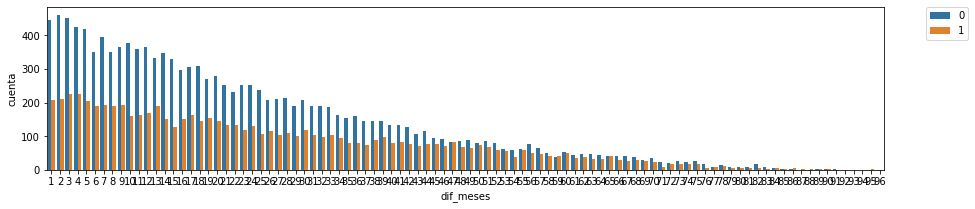

In [76]:
bg = base_t.groupby(['dif_meses','no_ad'])['id'].count().reset_index( name = 'cuenta' ).sort_values('cuenta', ascending = False)

fig, ax = plt.subplots(figsize=(15, 3))
ax = sns.barplot(x="dif_meses", y="cuenta", hue="no_ad", data=bg)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [84]:
n_meses = 6
#n_miss = 3

base_x = base_t[ base_t['dif_meses'] <= n_meses ]

In [78]:
base_x[base_x['id']==500547].head(14)

,id,year,month,no_ad,year_d,month_d,dif_meses
17,500547,2019,10,0,2019,12,2
18,500547,2019,10,0,2020,1,3
19,500547,2019,10,0,2020,3,5
25,500547,2019,12,0,2020,1,1
26,500547,2019,12,0,2020,3,3
27,500547,2019,12,0,2020,5,5
33,500547,2020,1,0,2020,3,2
34,500547,2020,1,0,2020,5,4
41,500547,2020,3,0,2020,5,2


In [85]:
base_m = base_x.groupby(ids)['no_ad'].count().reset_index( name = 'cuenta' )
base_m = base_m[ base_m['cuenta'] >= n_miss]
base_m.shape

(295, 4)